In [1]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import time
import sys
import os

In [2]:
# preamble for jupyter notebook and django
import django
import platform

if platform.node() == "mcc-apsis":
    sys.path.append('/home/leey/tmv/BasicBrowser/')
else:
    # local paths
    sys.path.append('/media/Data/MCC/tmv/BasicBrowser/')

os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

# import from appended path
import parliament.models as pm
from parliament.tasks import do_search, run_tm
import cities.models as cmodels
from django.contrib.auth.models import User
from tmv_app.models import *
from utils.tm_mgmt import update_topic_scores
from django.db.models import Q, Count, Func, F, Sum, Avg, Value as V

from utils.topic_comparison import compare_topic_queryset, save_res, sort_matrix, draw_score_matrix
from utils.topic_comparison import save_topic_list_as_table, draw_bipartite_topic_graph, bipartite_graph_from_matrix

In [3]:
#RunStats.objects.filter(psearch__title="Kohle pdf utterance", method='NM', K=50)

In [11]:
K1 = 20
K2 = 30
method = 'NM'
search_word = "Kohle"
run_id1 = RunStats.objects.get(psearch__title="{} tei paragraph".format(search_word), method=method, K=K1).run_id
run_id2 = RunStats.objects.get(psearch__title="{} tei paragraph".format(search_word), method=method, K=K2).run_id

stat1 = RunStats.objects.get(pk=run_id1)
topics1 = Topic.objects.filter(run_id=stat1.parent_run_id).order_by('-score')

stat2 = RunStats.objects.get(pk=run_id2)
topics2 = Topic.objects.filter(run_id=stat2.parent_run_id).order_by('-score')

In [6]:
save_topic_list_as_table(topics1, "topic_list_{}_{}_K{}_tei.csv".format(search_word, method, K))

0

['run_969_topics_30', 'scores_969', 'similarity_969-973', 'run_973_topics_30', 'scores_973']
C2:C30
matching sum:	67.0
max rows:	77.0
max cols:	74.0


0

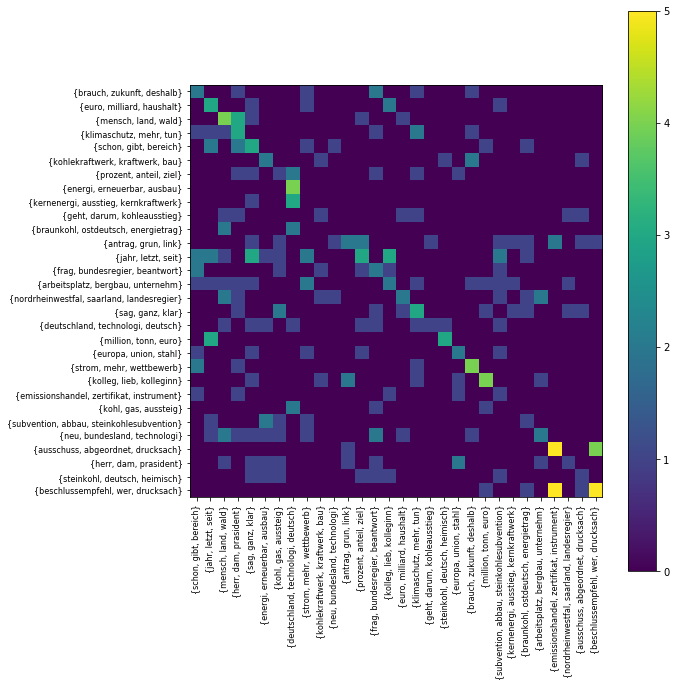

In [33]:
# Compares NMF and LDA methods for K=30
% matplotlib inline

runs = [run_id1, run_id2]
runs = [969,973]
runs = RunStats.objects.filter(pk__in=runs).order_by('K')

res_tw, ss, score_matrix = compare_topic_queryset(runs, order_by_str='-score')

options = {'fname': "/home/leey/coal-discourse"}
save_res(runs, [res_tw,ss], options)

#draw_score_matrix(score_matrix, topics1, topics2, match=True, filename="topword_score_matrix_{}_{}_K{}.pdf".format(search_word, method, K))
draw_score_matrix(score_matrix, topics1, topics2, match=True, filename="topword_score_matrix_{}_{}_K{}.png".format(search_word, method, K))

['run_968_topics_20', 'scores_968', 'similarity_968-969', 'run_969_topics_30', 'scores_969']
C2:C30
matching sum:	152.0
max rows:	152.0
max cols:	185.0


0

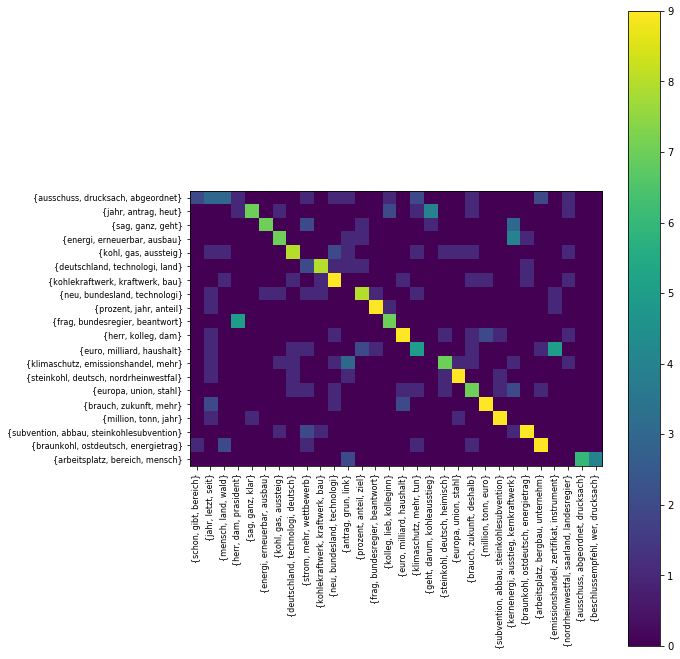

In [14]:
#Top Word Overlap comparison method
% matplotlib inline

runs = [run_id1, run_id2]
runs = RunStats.objects.filter(pk__in=runs).order_by('K')

res_tw, ss, score_matrix = compare_topic_queryset(runs, order_by_str='-score')

options = {'fname': "/home/leey/coal-discourse"}
save_res(runs, [res_tw,ss], options)

#draw_score_matrix(score_matrix[0], topics1, topics2, match=True, filename="topword_score_matrix_{}_{}_K{}.pdf".format(search_word, method, K))
draw_score_matrix(score_matrix, topics1, topics2, match=True, filename="topword_score_matrix_{}_{}_K{}_{}.png".format(search_word, method, K1, K2))

['run_968_topics_20', 'scores_968', 'similarity_968-969', 'run_969_topics_30', 'scores_969']
matching sum:	102.15815595566878
max rows:	102.15815595566879
max cols:	125.40763883634058


0

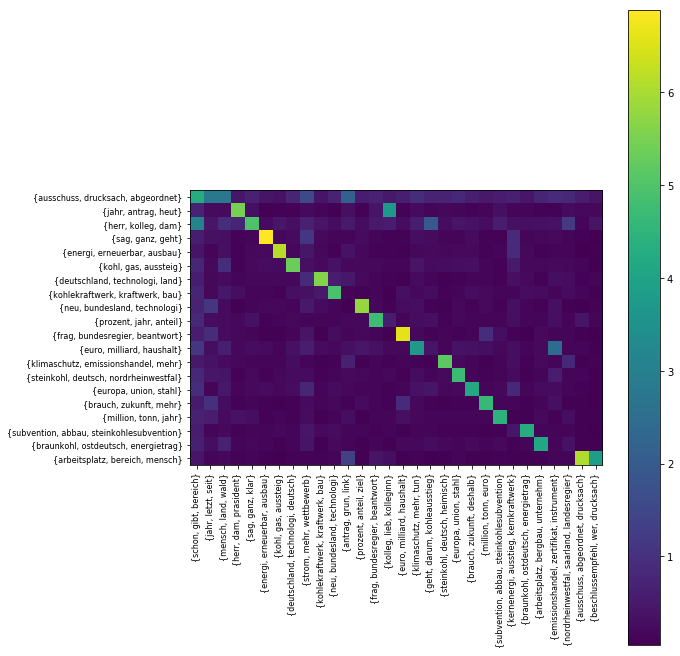

In [15]:
#Score Product comparison method
res, ss, score_prod_matrix = compare_topic_queryset(runs, method="score_product", order_by_str='-score')

#draw_score_matrix(score_prod_matrix, topics1, topics2, match=True, filename="prod_score_matrix_{}_{}_K{}.pdf".format(search_word, method, K))
draw_score_matrix(score_prod_matrix, topics1, topics2, match=True, filename="prod_score_matrix_{}_{}_K{}.png".format(search_word, method, K))

In [16]:
matrix1, permutation1 = sort_matrix(score_matrix)
matrix2, permutation2 = sort_matrix(score_prod_matrix)

sum(permutation1 == permutation2)

matching sum:	152.0
max rows:	152.0
max cols:	185.0
matching sum:	102.15815595566878
max rows:	102.15815595566879
max cols:	125.40763883634058


11

In [17]:
from termcolor import colored

def print_topics(topics1, topics2):
    
    for i in range(len(topics1)):
        sim_score = len(set(topics1[i].top_words).intersection(set(topics2[i].top_words)))

        if topics1[i].top_words == topics2[i].top_words:
            print("#{}: score: {}, matching".format(i, sim_score))
        elif sim_score > 5:
            print("#{}: score: {}, not matching".format(i, sim_score))
        else:
            print(colored("#{}: score: {}, not matching".format(i, sim_score), 'red'))

        print("{}\n{}".format(", ".join(topics1[i].top_words), ", ".join(topics2[i].top_words)))

matrix1, permutation1 = sort_matrix(score_matrix)
topic_list1 = [topics1[int(permutation1[i])] for i in range(len(topics1))]
        
print_topics(topic_list1, topics2)

matching sum:	152.0
max rows:	152.0
max cols:	185.0
#0: score: 2, not matching
jahr, antrag, heut, seit, land, unternehm, gross, mensch, mehr, schon
schon, gibt, bereich, gut, erst, word, punkt, gross, wichtig, beispiel
#1: score: 0, not matching
sag, ganz, geht, gesagt, imm, klar, red, thema, tun, nordrheinwestfal
jahr, letzt, seit, zehn, heut, deutsch, pro, lang, bundesregier, word
#2: score: 0, not matching
energi, erneuerbar, ausbau, strom, fossil, kernenergi, energiew, anteil, energiepolit, eeg
mensch, land, wald, region, rohstoff, nachhalt, betroff, heut, verantwort, leb
#3: score: 0, not matching
kohl, gas, aussteig, kernenergi, ausstieg, grun, energietrag, verbrenn, bleib, erdgas
herr, dam, prasident, geehrt, verehrt, minist, gabriel, gesagt, heut, herrn
#4: score: 0, not matching
deutschland, technologi, land, china, weltweit, ccs, kohleverstrom, welt, international, deutsch
sag, ganz, klar, red, imm, tun, thema, kohlesubvention, mocht, stell
#5: score: 0, not matching
kohlekr

In [18]:
matrix = score_matrix
if sum([row.max() for row in matrix]) > sum([col.max() for col in matrix.T]):
    permutation = [row.argmax() for row in matrix]
else:
    permutation = [col.argmax() for col in matrix.T]

topic_list2 = [topics2[int(permutation[i])] for i in range(K)]

print_topics(topics1, topic_list2)

#0: score: 2, not matching
jahr, antrag, heut, seit, land, unternehm, gross, mensch, mehr, schon
schon, gibt, bereich, gut, erst, word, punkt, gross, wichtig, beispiel
#1: score: 0, not matching
sag, ganz, geht, gesagt, imm, klar, red, thema, tun, nordrheinwestfal
schon, gibt, bereich, gut, erst, word, punkt, gross, wichtig, beispiel
#2: score: 0, not matching
herr, kolleg, dam, lieb, kolleginn, frau, geehrt, prasident, prasidentin, verehrt
schon, gibt, bereich, gut, erst, word, punkt, gross, wichtig, beispiel
#3: score: 0, not matching
energi, erneuerbar, ausbau, strom, fossil, kernenergi, energiew, anteil, energiepolit, eeg
mensch, land, wald, region, rohstoff, nachhalt, betroff, heut, verantwort, leb
#4: score: 0, not matching
kohl, gas, aussteig, kernenergi, ausstieg, grun, energietrag, verbrenn, bleib, erdgas
jahr, letzt, seit, zehn, heut, deutsch, pro, lang, bundesregier, word
#5: score: 0, not matching
deutschland, technologi, land, china, weltweit, ccs, kohleverstrom, welt, int

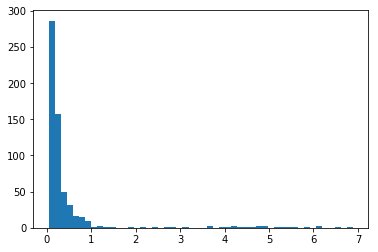

In [27]:
fig = plt.hist(score_prod_matrix.flatten(), bins=50)

In [28]:
matrix2, permutation2 = sort_matrix(score_matrix)
#print(permutation)
g = bipartite_graph_from_matrix(matrix2, threshold=1)
perm_topic_list = [topics1[int(permutation2[i])].title for i in range(K)]
draw_bipartite_topic_graph(g, perm_topic_list, topics2, filename='bipartite_topic_graph_{}_{}_K{}_topword_score'.format(search_word, method, K))

matching sum:	152.0
max rows:	152.0
max cols:	185.0


IndexError: index 20 is out of bounds for axis 0 with size 20

In [28]:
matrix1, permutation1 = sort_matrix(score_prod_matrix)
#print(permutation)
g = bipartite_graph_from_matrix(matrix1, threshold=1.5)
perm_topic_list = [topics1[int(permutation1[i])].title for i in range(K)]
draw_bipartite_topic_graph(g, perm_topic_list, topics2, filename="bipartite_topic_graph_{}_{}_K{}_prod_score".format(search_word, method, K))

NameError: name 'score_prod_matrix' is not defined

In [29]:
matrix1, permutation1 = sort_matrix(score_prod_matrix)
#print(permutation)
g = bipartite_graph_from_matrix(score_prod_matrix, threshold=1.5)
draw_bipartite_topic_graph(g, topics1, topics2, "bipartite_topic_graph_K{}_prod_score_not_sorted".format(K))

NameError: name 'score_prod_matrix' is not defined